<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20560 non-null  datetime64[ns]
 1   Temperature    20560 non-null  float64       
 2   Humidity       20560 non-null  float64       
 3   Light          20560 non-null  float64       
 4   CO2            20560 non-null  float64       
 5   HumidityRatio  20560 non-null  float64       
 6   Occupancy      20560 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.1 MB
None
                                date   Temperature      Humidity  \
count                          20560  20560.000000  20560.000000   
mean   2015-02-10 13:42:06.146984448     20.906212     27.655925   
min              2015-02-02 14:19:00     19.000000     16.745000   
25%              2015-02-06 11:05:45     20.200000     24.500000   
50%              20

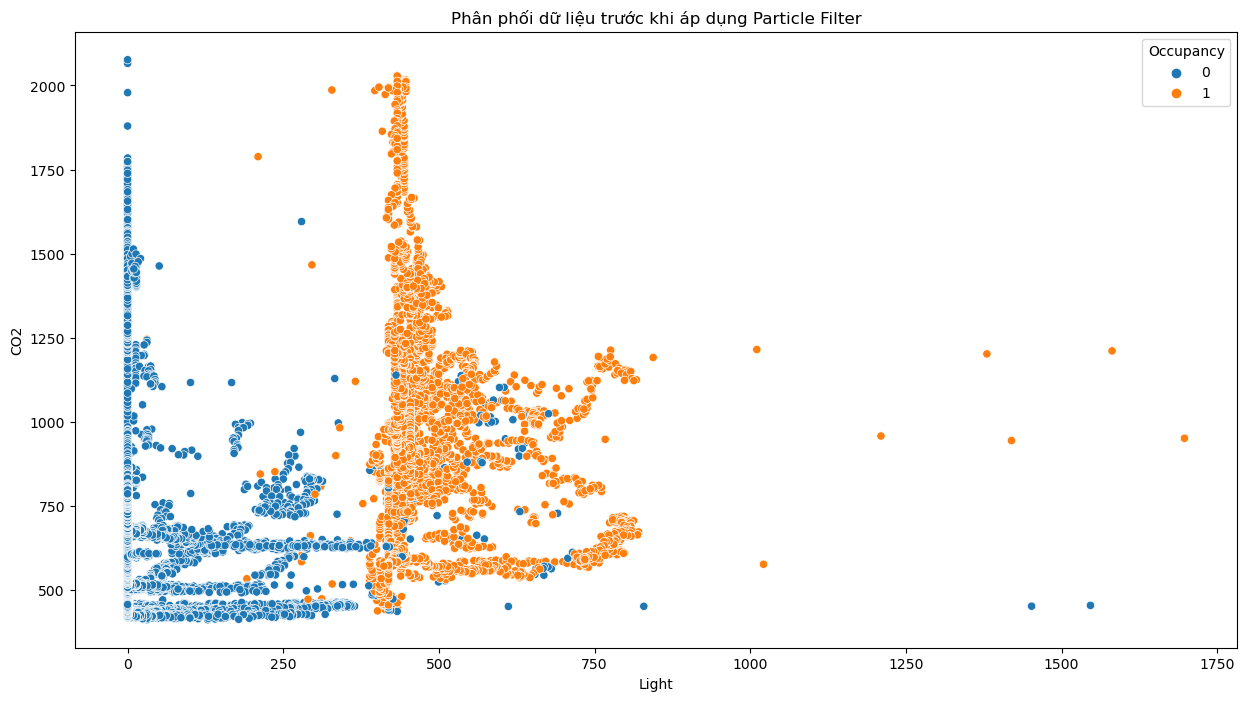


Không dùng Particle Filter:


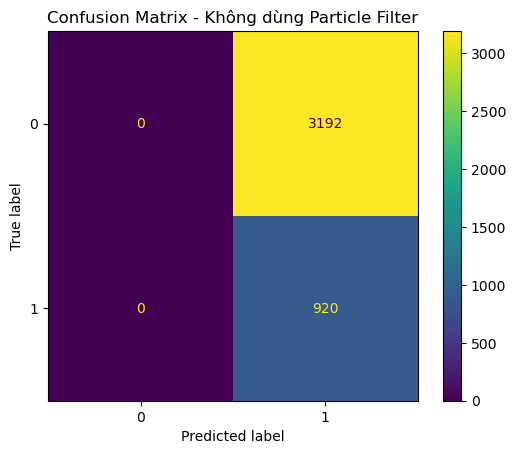

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3192
           1       0.22      1.00      0.37       920

    accuracy                           0.22      4112
   macro avg       0.11      0.50      0.18      4112
weighted avg       0.05      0.22      0.08      4112


Có dùng Particle Filter:


c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


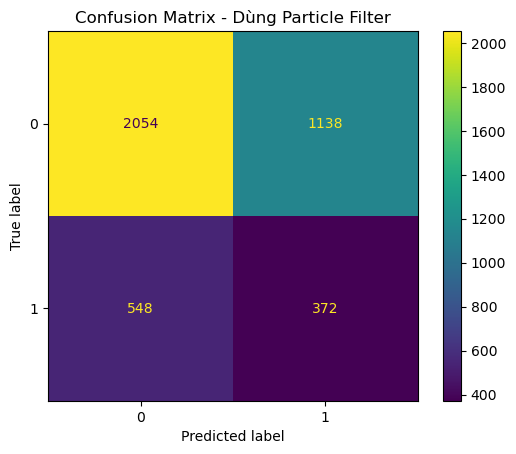

              precision    recall  f1-score   support

           0       0.79      0.64      0.71      3192
           1       0.25      0.40      0.31       920

    accuracy                           0.59      4112
   macro avg       0.52      0.52      0.51      4112
weighted avg       0.67      0.59      0.62      4112


Đánh giá hiệu suất mô hình - Không dùng Particle Filter:
Accuracy: 0.2237
Precision: 0.2237
Recall: 1.0000
F1-score: 0.3657
AUC: 0.5000

Đánh giá hiệu suất mô hình - Dùng Particle Filter:
Accuracy: 0.5900
Precision: 0.2464
Recall: 0.4043
F1-score: 0.3062
AUC: 0.5239

Đánh giá hiệu suất mô hình - Không dùng Particle Filter:
MSE: 0.7763
MAE: 0.7763
R² Score: -3.4696

Đánh giá hiệu suất mô hình - Dùng Particle Filter:
MSE: 0.2763
MAE: 0.2763
R² Score: -0.5907


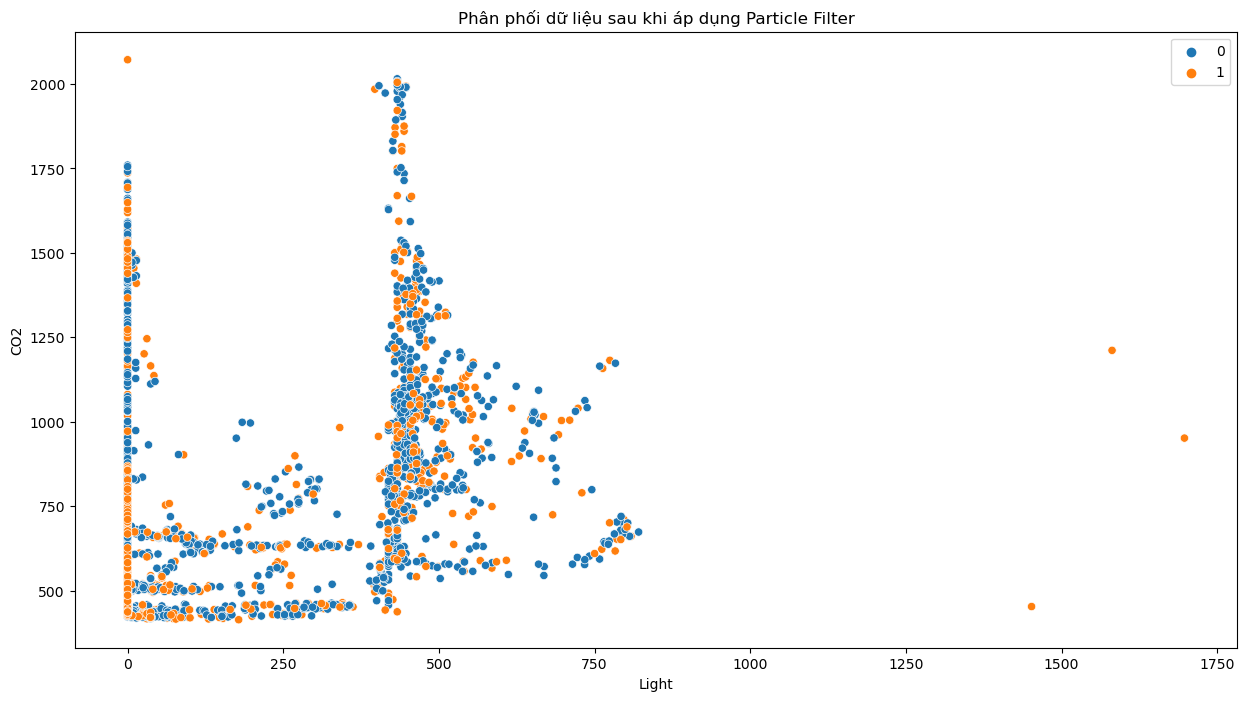

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
import math

file_path = (r"C:\Users\hoang\Downloads\Time-series\Occupancy..csv")
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])  # Chuyển đổi cột thời gian

# Kiểm tra phân phối dữ liệu
print(data.info())
print(data.describe())
print(data.head())

# Tách đặc trưng và nhãn
features = data[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].values
labels = data['Occupancy'].values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Vẽ phân phối dữ liệu trước khi áp dụng Particle Filter
plt.figure(figsize=(15, 8))
sns.scatterplot(x=data['Light'], y=data['CO2'], hue=data['Occupancy'])
plt.title('Phân phối dữ liệu trước khi áp dụng Particle Filter')
plt.xlabel('Light')
plt.ylabel('CO2')
plt.show()

# Xây dựng Particle Filter (PF) cho HMM phi tuyến không dùng thư viện
class ParticleFilter:
    def __init__(self, num_particles, state_dim):
        self.num_particles = num_particles
        self.state_dim = state_dim
        self.particles = np.random.rand(num_particles, state_dim)
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, process_noise=0.1):
        # Mô phỏng quá trình chuyển trạng thái (HMM process)
        for i in range(self.num_particles):
            self.particles[i] += np.random.normal(0, process_noise, self.state_dim)

    def update(self, measurement, measurement_noise=0.1):
        # Tính khoảng cách Euclidean và cập nhật trọng số
        epsilon = 1e-300  # Tránh chia cho 0
        total_weight = 0
        for i in range(self.num_particles):
            distance = math.sqrt(sum((self.particles[i] - measurement) ** 2))
            self.weights[i] = math.exp(-distance ** 2 / (2 * measurement_noise ** 2))
            total_weight += self.weights[i]
        # Chuẩn hóa trọng số
        if total_weight > epsilon:
            self.weights = [w / total_weight for w in self.weights]
        else:
            self.weights = np.ones(self.num_particles) / self.num_particles

    def resample(self):
        # Resampling theo trọng số (Sequential Importance Resampling - SIR)
        indices = []
        cumulative_sum = np.cumsum(self.weights)
        step = 1.0 / self.num_particles
        r = random.uniform(0, step)
        j = 0
        for _ in range(self.num_particles):
            while r > cumulative_sum[j]:
                j += 1
            indices.append(j)
            r += step
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        # Tính trung bình trạng thái dự đoán (phần xấp xỉ của HMM)
        return np.mean(self.particles, axis=0)

# Khởi tạo Particle Filter
pf = ParticleFilter(num_particles=1000, state_dim=5)

# So sánh dự đoán với và không dùng Particle Filter
# Không dùng Particle Filter (chỉ dùng giá trị trung bình)
predictions_no_pf = [1 if x.mean() > 0.5 else 0 for x in X_test]

# Dùng Particle Filter
predictions_pf = []
for i in range(len(X_test)):
    pf.predict()
    pf.update(X_test[i])
    # Phân loại dựa trên trung bình của tất cả các hạt
    predictions_pf.append(1 if pf.estimate().mean() > 0.5 else 0)

# Đánh giá kết quả không dùng PF
print("\nKhông dùng Particle Filter:")
cm_no_pf = confusion_matrix(y_test, predictions_no_pf)
ConfusionMatrixDisplay(cm_no_pf).plot()
plt.title("Confusion Matrix - Không dùng Particle Filter")
plt.show()

print(classification_report(y_test, predictions_no_pf))

# Đánh giá kết quả có dùng PF
print("\nCó dùng Particle Filter:")
cm_pf = confusion_matrix(y_test, predictions_pf)
ConfusionMatrixDisplay(cm_pf).plot()
plt.title("Confusion Matrix - Dùng Particle Filter")
plt.show()

print(classification_report(y_test, predictions_pf))

# 1. Tính các chỉ số phân loại cho mô hình không dùng Particle Filter
accuracy_no_pf = accuracy_score(y_test, predictions_no_pf)
precision_no_pf = precision_score(y_test, predictions_no_pf)
recall_no_pf = recall_score(y_test, predictions_no_pf)
f1_no_pf = f1_score(y_test, predictions_no_pf)
roc_auc_no_pf = roc_auc_score(y_test, predictions_no_pf)

# 2. Tính các chỉ số phân loại cho mô hình có dùng Particle Filter
accuracy_pf = accuracy_score(y_test, predictions_pf)
precision_pf = precision_score(y_test, predictions_pf)
recall_pf = recall_score(y_test, predictions_pf)
f1_pf = f1_score(y_test, predictions_pf)
roc_auc_pf = roc_auc_score(y_test, predictions_pf)

# 3. In kết quả
print("\nĐánh giá hiệu suất mô hình - Không dùng Particle Filter:")
print(f"Accuracy: {accuracy_no_pf:.4f}")
print(f"Precision: {precision_no_pf:.4f}")
print(f"Recall: {recall_no_pf:.4f}")
print(f"F1-score: {f1_no_pf:.4f}")
print(f"AUC: {roc_auc_no_pf:.4f}")

print("\nĐánh giá hiệu suất mô hình - Dùng Particle Filter:")
print(f"Accuracy: {accuracy_pf:.4f}")
print(f"Precision: {precision_pf:.4f}")
print(f"Recall: {recall_pf:.4f}")
print(f"F1-score: {f1_pf:.4f}")
print(f"AUC: {roc_auc_pf:.4f}")

# Vẽ biểu đồ so sánh phân phối sau khi dùng PF
plt.figure(figsize=(15, 8))
sns.scatterplot(x=X_test[:, 2], y=X_test[:, 3], hue=predictions_pf)
plt.title('Phân phối dữ liệu sau khi áp dụng Particle Filter')
plt.xlabel('Light')
plt.ylabel('CO2')
plt.show()
